# 9.프로젝트: 영화리뷰 감성분석.
##### !. Google colab pro에서 작성되었습니다.


---

### (본문)

### STEP 0: 주요 라이브러리 import

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# colab에서 konlpy 설치
!apt-get update
!apt-get install g++ openjdk-8-jdk python-dev python3-dev
!pip3 install JPype1
!pip3 install konlpy

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packa

In [4]:
# 환경변수 설정
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"


env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [5]:
# mecab 설치
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

Installing automake (A dependency for mecab-ko)
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists...
Reading 

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 5.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  3362k      0 --:--:-- --:--:-- --:--:-- 3362k
./configure: line 7378: /usr/bin/file: No such file or directory
In file included from viterbi.cpp:14:0:
param.h:30:13: warning: 'Target {anonymous}::lexical_cast(Source) [with Target = std::__cxx11::basic_string<char>; Source = std::_

In [6]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.5
0.6.0
3.6.0


In [8]:
from konlpy.tag import Mecab
mecab = Mecab()
sentence = "colab mecab 작동 확인"
mecab.morphs(sentence)

['colab', 'mecab', '작동', '확인']

### STEP 1: 데이터 준비와 확인

한국어 텍스트의 감정분석 진행을 위해 사용한 데이터셋은 네이벼 영화의 댓글을 모아 구성된 naver sentiment movie corpus.  
link. https://github.com/e9t/nsmc

In [11]:
import pandas as pd
# 데이터를 읽어오기
train_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/E_09_prepadding/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/E_09_prepadding/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### STEP 2: 데이터로더 구성

<구현기능>  
1) 데이터 중복 제거 - drop_duplicates활용  
2) NaN 결측치 제거 - dropna 활용  
3) 한국어 토크나이저로 토큰화 - Mecab().morphs 메소드 활용  
4) 불용어(Stopwords)제거 - Stopwrds 리스트를 이용해 제거  
5) 사전 word_to_index 구성  
6) 텍스트 스트링을 사전 인덱스 스트링으로 변환  
7) X_train, y_train, X_test, y_test, word_to_index 리턴  

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from collections import Counter
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
  train_data.drop_duplicates(subset=['document'], inplace=True)  # 데이터 중복 제거
  train_data = train_data.dropna(how = 'any')  # NaN 결측치 제거
  test_data.drop_duplicates(subset=['document'], inplace=True)  # 데이터 중복 제거
  test_data = test_data.dropna(how = 'any')  # NaN 결측치 제거
  
  X_train = []  # 학습용 데이터
  for sentence in train_data['document']:
      temp_X = tokenizer.morphs(sentence) # 토큰화
      temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
      X_train.append(temp_X)  # 단어 저장

  X_test = []  # 테스트용 데이터
  for sentence in test_data['document']:
      temp_X = tokenizer.morphs(sentence) # 토큰화
      temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
      X_test.append(temp_X)  # 단어 저장
  
  words = np.concatenate(X_train).tolist()  # array 합치고 list로 변환
  counter = Counter(words)  # list의 요소 개수 세기 => 딕셔너리 {단어: 개수} 형태로 반환
  counter = counter.most_common(10000-4)  # 최빈값 (10000-4)개 => 가장 마지막 4개를 제외한 나머지
  vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  # 단어 저장 list # <PAD>, <BOS>, <UNK>, <UNUSED>
  word_to_index = {word:index for index, word in enumerate(vocab)}  # 딕셔너리 {단어: 인덱스} 형태
  
  # 중첩 함수
  def wordlist_to_indexlist(wordlist):
      return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
      
  # list(map(함수, 리스트)): 리스트의 모든 요소를 지정된 함수로 처리한 결과를 리스트로 만듦
  X_train = list(map(wordlist_to_indexlist, X_train))
  X_test = list(map(wordlist_to_indexlist, X_test))
      
  return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [14]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [15]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [16]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 설정
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### STEP 3: 모델 구성을 위한 데이터 분석 및 가공

데이터셋 내 문장 길이 분포

In [17]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


적절한 최대 문장 길이 지정

In [18]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [19]:
# 짧은 문장 앞(pre)에 패딩 추가. post보다 pre가 효율이 더 좋음!
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)  # (146182, 41)
print(X_test.shape)  # (49157, 41)

(146182, 41)
(49157, 41)


### STEP 4: 델 구성 및 validation set 구성

모델을 3가지 이상 다양하게 구성하여 실험

In [20]:
vocab_size = len(word_to_index)  # 어휘 사전의 크기: 10000개 단어
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수. (변경 가능한 하이퍼 파라미터)

Model 1. RNN(LSTM)

In [21]:
# 모델 1: RNN (LSTM)

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용. 이때 LSTM state 벡터의 차원수는 8개 (변경 가능)
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


Model 2. 1-D CNN

In [22]:
# 모델 2: 1-D CNN

model_1d_cnn = tf.keras.Sequential()
model_1d_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1d_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1d_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_1d_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1d_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_1d_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_1d_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_1d_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         2000000   
                                                                 
 conv1d (Conv1D)             (None, None, 16)          22416     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

Model 3: GlobalMaxPooling1D() 레이어 1개만 사용

In [23]:
# 모델 3: GlobalMaxPooling1D() 레이어 1개만 사용

model_gmp1d = tf.keras.Sequential()
model_gmp1d.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp1d.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp1d.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp1d.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim.

model_gmp1d.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 200)         2000000   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 1608      
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


### STEP 5: 모델 훈련 개시

In [24]:
# Train : Validation : Test 을 일반적으로 6 : 2 : 2로 이용

# 일반적으로 전체 데이터 중 80%를 학습으로, 20%를 검증으로 사용하는 것이 좋음.
# validation set (총 데이터 개수 * 0.2)건 분리
x_val_len = int(len(X_train)*0.2)
y_val_len = int(len(y_train)*0.2)

x_val = X_train[:x_val_len]   
y_val = y_train[:y_val_len]

print(x_val.shape)  # (29236, 41)
print(y_val.shape)  # (29236,)

# validation set을 제외한 나머지 (총 데이터 개수 * 0.8)건
partial_x_train = X_train[x_val_len:]  
partial_y_train = y_train[y_val_len:]

print(partial_x_train.shape)  # (116946, 41)
print(partial_y_train.shape)  # (116946,)

(29236, 41)
(29236,)
(116946, 41)
(116946,)


너무 많은 Epoch는 overfitting을 일으킴.  
너무 적은 Epoch는 underfitting을 일으킴.  
적절한 수치 설정이 필요.  
Epoch을 정할 때는 Early stopping을 사용 하는 것이 좋음.  
학습률이 어느 순간부터 내려가지 않고 오히려 증가할 때가 있는데 이순간부터 학습은 무의미 하기 때문.  

In [25]:
from keras.callbacks import EarlyStopping

# monitor='val_loss': validation set 의 loss 를 monitoring 한다.
# mode='min': loss 의 경우, performance measure가 최소화 시키는 방향으로 training 이 진행되므로 min 을 지정함. -> keras에서 알아서 적절한 epoch에서 training을 멈춤.
# verbose=1: 언제 keras 에서 training 을 멈추었는지를 화면에 출력할 수 있음.
# patience=5: patience 는 성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인가를 주관적 기준으로 정의함. 성능이 증가하지 않는다고 바로 멈추는 것은 효과적이지 않을 수 있기 때문. 사용한 데이터와 모델의 설계에 따라 최적의 값이 바뀔 수 있음. 
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

Model 1. RNN(LSTM)

In [26]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 변경.

history_lstm = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])


Epoch 1/5
229/229 [==============================] - 11s 12ms/step - loss: 0.4452 - accuracy: 0.8069 - val_loss: 0.3529 - val_accuracy: 0.8481
Epoch 2/5
229/229 [==============================] - 2s 9ms/step - loss: 0.3222 - accuracy: 0.8654 - val_loss: 0.3404 - val_accuracy: 0.8516
Epoch 3/5
229/229 [==============================] - 2s 9ms/step - loss: 0.2906 - accuracy: 0.8804 - val_loss: 0.3447 - val_accuracy: 0.8538
Epoch 4/5
229/229 [==============================] - 2s 10ms/step - loss: 0.2651 - accuracy: 0.8919 - val_loss: 0.3523 - val_accuracy: 0.8522
Epoch 5/5
229/229 [==============================] - 2s 9ms/step - loss: 0.2421 - accuracy: 0.9032 - val_loss: 0.3645 - val_accuracy: 0.8516


In [27]:
# 모델 평가
results_lstm = model_lstm.evaluate(X_test,  y_test, verbose=2)  # (loss, accuracy)

print(results_lstm)  # (0.3731, 0.8462)

1537/1537 - 6s - loss: 0.3732 - accuracy: 0.8463 - 6s/epoch - 4ms/step
[0.3731676936149597, 0.8462680578231812]


model 2. 1-D CNN

In [28]:
model_1d_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 변경. 

history_1d_cnn = model_1d_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/5
229/229 [==============================] - 11s 9ms/step - loss: 0.4696 - accuracy: 0.7634 - val_loss: 0.3404 - val_accuracy: 0.8520
Epoch 2/5
229/229 [==============================] - 2s 8ms/step - loss: 0.3050 - accuracy: 0.8714 - val_loss: 0.3243 - val_accuracy: 0.8608
Epoch 3/5
229/229 [==============================] - 2s 8ms/step - loss: 0.2474 - accuracy: 0.9009 - val_loss: 0.3378 - val_accuracy: 0.8565
Epoch 4/5
229/229 [==============================] - 2s 8ms/step - loss: 0.1843 - accuracy: 0.9321 - val_loss: 0.3707 - val_accuracy: 0.8525
Epoch 5/5
229/229 [==============================] - 2s 8ms/step - loss: 0.1223 - accuracy: 0.9584 - val_loss: 0.4293 - val_accuracy: 0.8447


In [29]:
# 모델 평가
results_1d_cnn = model_1d_cnn.evaluate(X_test,  y_test, verbose=2)  # (loss, accuracy)

print(results_1d_cnn)  # (0.4426, 0.8418)

1537/1537 - 4s - loss: 0.4426 - accuracy: 0.8419 - 4s/epoch - 2ms/step
[0.44261184334754944, 0.841853678226471]


model 3. GlobarMaxPooling1D() 1개만 사용

In [30]:
model_gmp1d.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gmp1d = model_gmp1d.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/5
229/229 [==============================] - 3s 7ms/step - loss: 0.4978 - accuracy: 0.7713 - val_loss: 0.3543 - val_accuracy: 0.8467
Epoch 2/5
229/229 [==============================] - 2s 7ms/step - loss: 0.3196 - accuracy: 0.8653 - val_loss: 0.3343 - val_accuracy: 0.8540
Epoch 3/5
229/229 [==============================] - 2s 7ms/step - loss: 0.2704 - accuracy: 0.8897 - val_loss: 0.3387 - val_accuracy: 0.8558
Epoch 4/5
229/229 [==============================] - 2s 7ms/step - loss: 0.2302 - accuracy: 0.9098 - val_loss: 0.3544 - val_accuracy: 0.8551
Epoch 5/5
229/229 [==============================] - 2s 7ms/step - loss: 0.1903 - accuracy: 0.9298 - val_loss: 0.3743 - val_accuracy: 0.8547


In [31]:
# 모델 평가
results_gmp1d = model_gmp1d.evaluate(X_test,  y_test, verbose=2)  # (loss, accuracy)

print(results_gmp1d)  # (0.3848, 0.8462)

1537/1537 - 3s - loss: 0.3849 - accuracy: 0.8463 - 3s/epoch - 2ms/step
[0.3848690390586853, 0.8462884426116943]


model 평가 확인(loss, accuracy)

|NUM|Model|Loss|Accuracy |
|:---|:---|:---|:---|
|1|RNN(LSTM) |0.3732 |0.8463 |
|2|1-D CNN |0.4426 |0.8419 |
|3|GlobalMaxPooling1D() 레이어 1개 |0.3849 |0.8463 |

세 모델 전부 성능이 비슷함.  
accuracy만 봤을 때는 가장 높은 RNN(LSTM)이 좋음.  
loss만 봤을 때는 값이 가장 낮은 RNN(LSTM)이 좋음.  

### STEP 6: Loss, Accuracy 그래프 시각화


model 1. RNN(LSTM)


In [32]:
history_dict = history_lstm.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [33]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


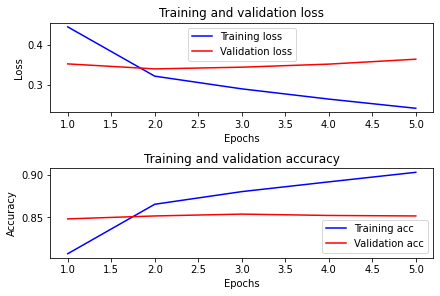

In [34]:
# Subplot들의 간격 조정하기

# plt.subplots
fig, axs = plt.subplots(2 ,1, constrained_layout=True)

# Training and Validation Loss 그래프
axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Training and Validation Accuracy 그래프
axs[1].plot(epochs, acc, 'b', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

model 2. 1-D CNN

In [35]:
history_dict = history_1d_cnn.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [36]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

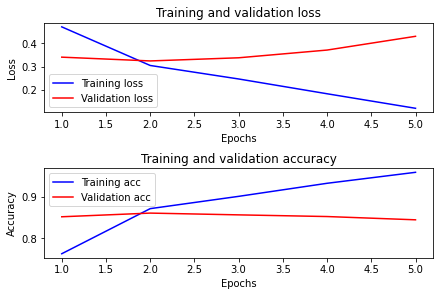

In [37]:
# Subplot들의 간격 조정하기

# plt.subplots
fig, axs = plt.subplots(2 ,1, constrained_layout=True)

# Training and Validation Loss 그래프
axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Training and Validation Accuracy 그래프
axs[1].plot(epochs, acc, 'b', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

model 3. GloablMaxPooling1D() 레이어 1개만 사용

In [38]:
history_dict = history_gmp1d.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [39]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

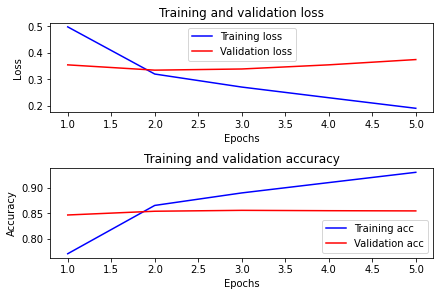

In [40]:
# Subplot들의 간격 조정하기

# plt.subplots
fig, axs = plt.subplots(2 ,1, constrained_layout=True)

# Training and Validation Loss 그래프
axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Training and Validation Accuracy 그래프
axs[1].plot(epochs, acc, 'b', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

### STEP 7: 학습된 Embedding 레이어 분석

In [41]:
from gensim.models.keyedvectors import Word2VecKeyedVectors


model 1.: RNN(LSTM)

In [42]:
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [44]:
# 학습한 Embedding 파라미터를 파일에 써서 저장.
word2vec_file_path = '/content/drive/MyDrive/Colab Notebooks/E_09_prepadding/word2vec_LSTM.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씀.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [45]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector


array([-0.00251032,  0.02193392, -0.07954747,  0.01892787,  0.03066609,
        0.04394497, -0.03626507, -0.00590606,  0.21428299, -0.02496716,
       -0.04041804,  0.06170689, -0.06779327, -0.06410491, -0.08527839,
       -0.04265247, -0.03979846, -0.00693131,  0.00089954,  0.16963126,
       -0.05003798,  0.02498322, -0.04668896, -0.00624096,  0.00602066,
        0.0145281 ,  0.02375497,  0.00613514, -0.08588785,  0.04671326,
        0.01762261, -0.03717809,  0.02542754,  0.02298426,  0.03548749,
        0.03778076,  0.02118653,  0.06860656,  0.04984046,  0.05961598,
        0.01421195,  0.03688365,  0.03904061, -0.02292111, -0.0028008 ,
        0.06974506,  0.00929688, -0.04337531, -0.03347034,  0.01524474,
        0.0970582 ,  0.01106387,  0.00201866,  0.04114758,  0.06222537,
        0.00358674, -0.08502685, -0.05145928,  0.09074693, -0.0716532 ,
       -0.04584777, -0.00180288, -0.04250442,  0.01035316,  0.04589722,
       -0.03326118, -0.0343415 ,  0.0196231 , -0.01966601, -0.04

In [46]:
# 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하기
# => 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법
word_vectors.similar_by_word("재미")  # 유사 단어와 유사도 확인

[('넘', 0.6137239933013916),
 ('완전', 0.579594612121582),
 ('졸라', 0.5731600522994995),
 ('노튼', 0.5729647874832153),
 ('거의', 0.5566143989562988),
 ('가치', 0.5461827516555786),
 ('임창정', 0.541965901851654),
 ('매우', 0.5033533573150635),
 ('편집', 0.5024120211601257),
 ('이뻐서', 0.5016900300979614)]

In [47]:
word_vectors.similar_by_word("최고")

[('굿', 0.9023435115814209),
 ('best', 0.8829773664474487),
 ('완벽', 0.8690271377563477),
 ('수준급', 0.8677071332931519),
 ('입감', 0.8637330532073975),
 ('펑펑', 0.8634947538375854),
 ('먹먹', 0.8614240884780884),
 ('김현주', 0.8535425066947937),
 ('만점', 0.8529133200645447),
 ('명품', 0.8528481721878052)]

In [48]:
word_vectors.similar_by_word("별로")

[('실망', 0.9288640022277832),
 ('졸작', 0.9287555813789368),
 ('억지', 0.9265146255493164),
 ('지루함', 0.9158774614334106),
 ('ㅗ', 0.9105595350265503),
 ('재미없', 0.9090059995651245),
 ('쓰레기', 0.9037079811096191),
 ('그나마', 0.9025091528892517),
 ('싸구려', 0.9020494818687439),
 ('에휴', 0.9004274010658264)]

In [49]:
word_vectors.similar_by_word("엉엉")

[('젊은이', 0.8356455564498901),
 ('리암니슨', 0.8308484554290771),
 ('후딱', 0.8289674520492554),
 ('아련', 0.8278641700744629),
 ('소장', 0.8233500719070435),
 ('통쾌', 0.8227800130844116),
 ('이상우', 0.8205659985542297),
 ('러블리', 0.820143461227417),
 ('저격', 0.8179866075515747),
 ('미소', 0.817225992679596)]

In [50]:
word_vectors.similar_by_word("매력")

[('울리', 0.770054817199707),
 ('꾀', 0.7629830837249756),
 ('조명', 0.7595920562744141),
 ('따뜻', 0.7569880485534668),
 ('삶', 0.7566399574279785),
 ('이동욱', 0.7522501349449158),
 ('최소', 0.7519397735595703),
 ('배꼽', 0.7461928725242615),
 ('만점', 0.7459065318107605),
 ('9', 0.7358129024505615)]

In [51]:
word_vectors.similar_by_word("반전")

[('즈', 0.4842531085014343),
 ('매력', 0.4827805757522583),
 ('긴장감', 0.4769734740257263),
 ('캐', 0.476191908121109),
 ('모두', 0.47346195578575134),
 ('정말', 0.47232991456985474),
 ('경', 0.460411012172699),
 ('웃겼', 0.45727336406707764),
 ('옳', 0.456887423992157),
 ('매우', 0.4514549672603607)]

model 2. 1-D CNN

In [52]:
embedding_layer = model_1d_cnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [53]:
# 학습한 Embedding 파라미터를 파일에 써서 저장.
word2vec_file_path = '/content/drive/MyDrive/Colab Notebooks/E_09_prepadding/word2vec_1-D_CNN.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씀.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록.
vectors = model_1d_cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [55]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([ 0.04609175, -0.05851559,  0.01501419,  0.04296179, -0.12906049,
        0.02323695, -0.01880247,  0.06068986,  0.00655144, -0.01015439,
       -0.0268273 ,  0.00173804,  0.05826287, -0.00664427, -0.04668094,
        0.04135815,  0.02301864,  0.09245155, -0.02358383,  0.04933058,
        0.00732265,  0.02322743, -0.08051575,  0.03188253,  0.05687852,
        0.13324478,  0.00216596,  0.01028928,  0.06785078, -0.0135653 ,
       -0.09510765,  0.00600418,  0.05238027,  0.02787614, -0.02473961,
       -0.06411434, -0.07387856,  0.04700946,  0.14175583, -0.02686275,
       -0.11495031,  0.04183196,  0.01697793, -0.08889304,  0.09874385,
        0.00886641, -0.11756273, -0.03111787,  0.04772856,  0.06461158,
        0.00241604, -0.02004112,  0.01798999,  0.01297256,  0.0469755 ,
        0.01405275, -0.03813184,  0.15609242,  0.06560404, -0.02891611,
        0.01862369, -0.01809792,  0.15617524,  0.03722791,  0.02323025,
       -0.05338845,  0.00216675, -0.01836435, -0.00748463, -0.03

In [56]:
# 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하기
# => 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법
word_vectors.similar_by_word("재미")  # 유사 단어와 유사도 확인

[('열라', 0.5593023300170898),
 ('츄', 0.5476783514022827),
 ('살아남', 0.5314257144927979),
 ('수록', 0.5103436708450317),
 ('완전', 0.5083073377609253),
 ('그냥', 0.5035897493362427),
 ('너무나', 0.4998818337917328),
 ('박시후', 0.4956400990486145),
 ('와이프', 0.49056917428970337),
 ('릭터', 0.48279303312301636)]

In [57]:
word_vectors.similar_by_word("최고")

[('탄탄', 0.7823103666305542),
 ('박신혜', 0.7776232957839966),
 ('울컥', 0.7758581638336182),
 ('냉혹', 0.7756639719009399),
 ('귀여워', 0.7743080854415894),
 ('편도', 0.7735954523086548),
 ('호랑이', 0.7726014256477356),
 ('아련', 0.7711009979248047),
 ('되돌', 0.7688250541687012),
 ('빠져드', 0.7657099366188049)]

In [58]:
word_vectors.similar_by_word("별로")

[('왜곡', 0.8108786940574646),
 ('쓰레기', 0.802303671836853),
 ('꺼버렸', 0.8010953068733215),
 ('괴로웠', 0.798911988735199),
 ('졸작', 0.7978373169898987),
 ('무표정', 0.7941766977310181),
 ('역겨웠', 0.7866178750991821),
 ('신파', 0.7857794165611267),
 ('22', 0.7787376642227173),
 ('심한', 0.7759296894073486)]

In [59]:
word_vectors.similar_by_word("엉엉")

[('명불허전', 0.7809435129165649),
 ('일품', 0.7606977224349976),
 ('웨스턴', 0.7535937428474426),
 ('헌신', 0.7506539225578308),
 ('먹먹', 0.7505538463592529),
 ('담백', 0.7443456649780273),
 ('알차', 0.7423981428146362),
 ('돌이켜', 0.7396018505096436),
 ('엇갈리', 0.7389237880706787),
 ('펭귄', 0.7375900745391846)]

In [60]:
word_vectors.similar_by_word("매력")

[('굿', 0.6620068550109863),
 ('Good', 0.6616891622543335),
 ('먹먹', 0.6443746089935303),
 ('완벽', 0.6353598833084106),
 ('다가왔', 0.6334686875343323),
 ('새록새록', 0.6287807822227478),
 ('섬세', 0.6286115646362305),
 ('편도', 0.6263555288314819),
 ('충분', 0.6254851818084717),
 ('호랑이', 0.6232717633247375)]

In [61]:
word_vectors.similar_by_word("반전")

[('액티비티', 0.50238037109375),
 ('우분', 0.4979950487613678),
 ('볼거리', 0.49420642852783203),
 ('점주', 0.4933945834636688),
 ('암튼', 0.491188645362854),
 ('클로이', 0.48750948905944824),
 ('이토록', 0.4857295751571655),
 ('중독자', 0.48475345969200134),
 ('신인', 0.4816412329673767),
 ('매우', 0.48114803433418274)]

model 3.GlobalMaxPooling1D() 레이어 1개만 사용

In [62]:
embedding_layer = model_gmp1d.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [63]:
# 학습한 Embedding 파라미터를 파일에 써서 저장.
word2vec_file_path = '/content/drive/MyDrive/Colab Notebooks/E_09_prepadding/word2vec_GlobalMaxPooling1D.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씀.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록.
vectors = model_gmp1d.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [64]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.02099287,  0.01069293, -0.06274802, -0.06418448, -0.04661779,
       -0.05973652, -0.01235121, -0.00030585, -0.08388301, -0.04923777,
        0.12289818,  0.08816645, -0.0193158 , -0.06440979, -0.01824966,
       -0.0448675 ,  0.0503802 ,  0.00613892, -0.09176882, -0.08202576,
        0.04251565, -0.05042824, -0.06122954,  0.00543189, -0.04334769,
       -0.0267884 , -0.02162531,  0.09129565, -0.00740051, -0.01177217,
       -0.09805942, -0.00757235,  0.05880706, -0.03653218,  0.01748171,
       -0.0938031 , -0.07140782, -0.04817878, -0.00152112, -0.09550197,
       -0.08242395, -0.06356496,  0.04816174,  0.11506732,  0.05936591,
       -0.05532274, -0.06274372, -0.0443853 ,  0.12565576,  0.01912526,
       -0.04962948, -0.02001054, -0.08064616,  0.08796873,  0.05251354,
       -0.04657005, -0.00106133, -0.08514214, -0.06793911, -0.05223638,
       -0.08146052,  0.06209048, -0.04116701, -0.04399066, -0.05556847,
       -0.08283719, -0.03871851, -0.04866295, -0.04443757,  0.11

In [65]:
# 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하기
# => 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법
word_vectors.similar_by_word("재미")  # 유사 단어와 유사도 확인

[('것', 0.4640257954597473),
 ('음', 0.43361783027648926),
 ('고', 0.43062669038772583),
 ('임', 0.41328248381614685),
 ('자극', 0.41099685430526733),
 ('기대', 0.4034028649330139),
 ('까지', 0.3988420367240906),
 ('으', 0.396513432264328),
 ('두', 0.39359819889068604),
 ('야', 0.38840365409851074)]

In [66]:
word_vectors.similar_by_word("최고")

[('best', 0.4727030396461487),
 ('여운', 0.394523948431015),
 ('조디포스터', 0.360988974571228),
 ('감탄', 0.34297215938568115),
 ('귀여워', 0.3417710065841675),
 ('명작', 0.3400716781616211),
 ('달콤', 0.3384883999824524),
 ('엑소', 0.3329838514328003),
 ('빠져들', 0.3153648376464844),
 ('주목', 0.31348198652267456)]

In [67]:
word_vectors.similar_by_word("별로")

[('신파극', 0.534616231918335),
 ('싸구려', 0.5067594051361084),
 ('황당', 0.50589919090271),
 ('짱나', 0.5022119283676147),
 ('저질', 0.49174368381500244),
 ('진부', 0.48809146881103516),
 ('전기세', 0.4791407287120819),
 ('제작비', 0.47405290603637695),
 ('--;', 0.47117042541503906),
 ('표절', 0.4694526195526123)]

In [68]:
word_vectors.similar_by_word("엉엉")

[('아키라', 0.4472849369049072),
 ('탄탄', 0.41689568758010864),
 ('김아중', 0.4022742509841919),
 ('love', 0.39657729864120483),
 ('어우러진', 0.3786444664001465),
 ('절절', 0.3780074119567871),
 ('멋져요', 0.37413346767425537),
 ('해집니다', 0.374106228351593),
 ('즐겁', 0.37037450075149536),
 ('누군가', 0.36963462829589844)]

In [69]:
word_vectors.similar_by_word("매력")

[('랑', 0.3514373004436493),
 ('SF', 0.3482474684715271),
 ('기억', 0.34162160754203796),
 ('이해', 0.3415903151035309),
 ('님', 0.33040356636047363),
 ('스파이', 0.32686543464660645),
 ('년', 0.3190922141075134),
 ('어쨌든', 0.3162699043750763),
 ('ㅣ', 0.311206579208374),
 ('우아', 0.308046817779541)]

In [91]:
word_vectors.similar_by_word("반전")

[('고', 0.43923959136009216),
 ('음', 0.4337460994720459),
 ('연기', 0.42967671155929565),
 ('난', 0.42724257707595825),
 ('솔', 0.42608529329299927),
 ('..', 0.41735321283340454),
 ('웅', 0.41441062092781067),
 (',', 0.4088456630706787),
 ('상징', 0.40703925490379333),
 ('는데', 0.3964082896709442)]

word_vectors.wimiar_by_word()로 유사 단어 찾기 결론.  
감정과 관련한 단어를 인자로 넣으면 세 모델 어느정도 연관있는 단어를 뽑아내기도 했지만.  
그렇지 않은 것들도 더러 있었음. 특징으로는 부정보다는 긍정적인 단어를 더 잘 찾아내는 것 같음.   
감정과 관련 없는 단어는 아예 유사도가 없어(주관에 의하면) 보이는 단어들이 나옴.  
말 그대로 감정 분석이기에 이러한 결과가 나오는 듯함.  

### STEP 8: 한국어 Word2Vec 임베딩 활용하여 성능 개선

한국어 Word2Vec 출처: https://github.com/Kyubyong/wordvectors

gensim 3.x.x 버전으로 다운그레이드 진행
4.0.X버전부터는 vocab 코드가 gensim 패키지 안에서 사라졌기 때문에 ko.bin을 로드하려면 gensim 3.x.x 버전이 필요

In [71]:
!pip install --upgrade gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.2 MB 600 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


Word2Vec 모델 load 코드 수정

model. RNN(LSTM)  
앞서 진행한 세가지 모델 중 LSTM의 성능이 가장 좋았기 때문에 RNN(LSTM)으로 진행  
LSTM state vector의 차원 수를 256으로 변경해서 진행  


In [72]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [74]:
word2vec_path = '/content/drive/MyDrive/Colab Notebooks/E_09_prepadding/ko.bin'

word2vec = Word2Vec.load(word2vec_path)  # 학습한 모델 로드

# 완성된 임베딩 매트릭스의 크기 확인
print(word2vec.wv.vectors.shape)

vector = word2vec.wv.most_similar("재미")  # 메모리를 다소 많이 소비하는 작업이니 유의.
vector     # 무려 200dim의 워드 벡터.

(30185, 200)


[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [75]:
vocab_size = len(word_to_index)    # 어휘 사전의 크기(10,000개의 단어).
word_vector_dim = word2vec.wv.vectors.shape[1]  # 워드 벡터의 차원수 200.
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [76]:
from tensorflow.keras.initializers import Constant

RNN(LSTM)

In [77]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(256))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용. LSTM state 벡터의 차원수는 변경 가능
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 lstm_1 (LSTM)               (None, 256)               467968    
                                                                 
 dense_6 (Dense)             (None, 8)                 2056      
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,470,033
Trainable params: 2,470,033
Non-trainable params: 0
_________________________________________________________________


In [78]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 변경.

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])


Epoch 1/5
229/229 [==============================] - 8s 24ms/step - loss: 0.4510 - accuracy: 0.7825 - val_loss: 0.3720 - val_accuracy: 0.8316
Epoch 2/5
229/229 [==============================] - 5s 22ms/step - loss: 0.3211 - accuracy: 0.8609 - val_loss: 0.3202 - val_accuracy: 0.8605
Epoch 3/5
229/229 [==============================] - 5s 21ms/step - loss: 0.2753 - accuracy: 0.8847 - val_loss: 0.3130 - val_accuracy: 0.8644
Epoch 4/5
229/229 [==============================] - 5s 22ms/step - loss: 0.2414 - accuracy: 0.9007 - val_loss: 0.3122 - val_accuracy: 0.8670
Epoch 5/5
229/229 [==============================] - 5s 21ms/step - loss: 0.2095 - accuracy: 0.9158 - val_loss: 0.3228 - val_accuracy: 0.8695


In [79]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)  # (0.3294, 0.8658)

1537/1537 - 6s - loss: 0.3295 - accuracy: 0.8659 - 6s/epoch - 4ms/step
[0.3294706642627716, 0.865878701210022]


In [80]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [81]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

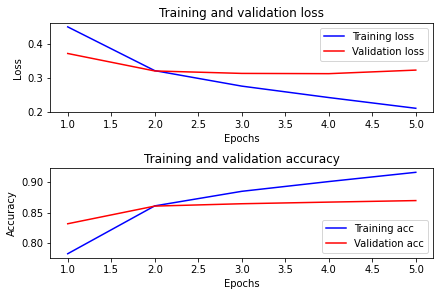

In [82]:
# Subplot들의 간격 조정하기.

# plt.subplots
fig, axs = plt.subplots(2 ,1, constrained_layout=True)

# Training and Validation Loss 그래프
axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Training and Validation Accuracy 그래프
axs[1].plot(epochs, acc, 'b', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

In [83]:
word_vectors.similar_by_word("재미")

[('것', 0.4640257954597473),
 ('음', 0.43361783027648926),
 ('고', 0.43062669038772583),
 ('임', 0.41328248381614685),
 ('자극', 0.41099685430526733),
 ('기대', 0.4034028649330139),
 ('까지', 0.3988420367240906),
 ('으', 0.396513432264328),
 ('두', 0.39359819889068604),
 ('야', 0.38840365409851074)]

In [84]:
word_vectors.similar_by_word("최고")

[('best', 0.4727030396461487),
 ('여운', 0.394523948431015),
 ('조디포스터', 0.360988974571228),
 ('감탄', 0.34297215938568115),
 ('귀여워', 0.3417710065841675),
 ('명작', 0.3400716781616211),
 ('달콤', 0.3384883999824524),
 ('엑소', 0.3329838514328003),
 ('빠져들', 0.3153648376464844),
 ('주목', 0.31348198652267456)]

In [85]:
word_vectors.similar_by_word("별로")

[('신파극', 0.534616231918335),
 ('싸구려', 0.5067594051361084),
 ('황당', 0.50589919090271),
 ('짱나', 0.5022119283676147),
 ('저질', 0.49174368381500244),
 ('진부', 0.48809146881103516),
 ('전기세', 0.4791407287120819),
 ('제작비', 0.47405290603637695),
 ('--;', 0.47117042541503906),
 ('표절', 0.4694526195526123)]

In [87]:
word_vectors.similar_by_word("눈물")

[('ㅠㅠㅠ', 0.41988405585289),
 ('ㅠㅠㅠㅠ', 0.391740083694458),
 ('기다려', 0.3821219205856323),
 ('번', 0.37703657150268555),
 ('달달', 0.3718520700931549),
 ('괜찮', 0.36662909388542175),
 ('수작', 0.36071711778640747),
 ('봣음', 0.35811468958854675),
 ('좋', 0.3569108843803406),
 ('지리', 0.35377681255340576)]

In [88]:
word_vectors.similar_by_word("매력")

[('랑', 0.3514373004436493),
 ('SF', 0.3482474684715271),
 ('기억', 0.34162160754203796),
 ('이해', 0.3415903151035309),
 ('님', 0.33040356636047363),
 ('스파이', 0.32686543464660645),
 ('년', 0.3190922141075134),
 ('어쨌든', 0.3162699043750763),
 ('ㅣ', 0.311206579208374),
 ('우아', 0.308046817779541)]

In [89]:
word_vectors.similar_by_word("반전")

[('고', 0.43923959136009216),
 ('음', 0.4337460994720459),
 ('연기', 0.42967671155929565),
 ('난', 0.42724257707595825),
 ('솔', 0.42608529329299927),
 ('..', 0.41735321283340454),
 ('웅', 0.41441062092781067),
 (',', 0.4088456630706787),
 ('상징', 0.40703925490379333),
 ('는데', 0.3964082896709442)]

모델 비교

|NUM|Model|Loss|Accuracy |
|:---|:---|:---|:---|
|1|RNN(LSTM) |0.3732 |0.8463 |
|2|ko.bin 임베딩 활용 LSTM |0.3294 |0.8659 |

결론.  
앞서 진행한 LSTM 모델과 카피한 임베딩을 활용한 LSTM 모댈의 loss와 accuracy를 비교했을 때 후자가 더 좋은 성능을 보이고 있음(LOSS는 더 낮고 Accuracy는 더 높음)  
유사 단어찾기도 후자 모델이 더 좋은 것처럼(주관적) 보임.

---

### 루브릭.

|평가문항|비고|상세기준|비고 |
|:---|:---:|:---|---:|
|1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. | |3가지 이상의 모델이 성공적으로 시도됨 | |
|2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다. | |gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함 | |
|3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다. | |네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함 | |

---

### 회고록.

자연어 처리의 흐름을 이해해 RNN과 CNN등을 활용하여 영화리뷰에 대한 감성분석을 진행해보는 9번째 Exploration이었다.  
텍스트 데이터가 컴퓨터가 분석이 가능하도록 벡터로 변환되는 복잡하고 수많은 계산 과정을 코드 몇줄로 처리되는 것이 대단하다고 느껴졌다.  
자연어에서 중복과 결측치, 불용어를 제거하고 토큰화를 시킨 다음에 인덱싱 후 데이터 train 데이터와 test 데이터를 split한 후 3가지 모델(LSTM, 1-D CNN, GloablMaxPooling1D) 을 설계하고 학습, 평가로 진행되는 흐름은 크게 어렵지 않았다(모델을 완전히 이해한 것은 아니다!).  
오히려 라이브러리 버전(Mecab, KoNLP)이 다르거나 colab환경이 받쳐주지 않아 굉장히 많은 시간을 환경구성에 필요한 정보를 알아내기 위한 구글링에 쏟아부었다.

결과출력도 사실 크게 마음에 들지 않았다.  
몇몇개는 입력값과 유사한 단어들을 찾아냈지만 한국어의 특성때문인지 영어랑 달리 정확도(주관적인)가 그리 높지 않다고 느껴졌다.  

작년 세미나에서 본 Naver hyper clova 같은 경우 GTP3를 기반으로한 NLP 결과가 마치 사람과 같이 느껴질정도였었는데 네이버만이 할 수 있는 초거대 빅데이터로 모델의 불합리함까지 이겨낸 것인지 궁금하다.  

자연어처리 프로젝트를 진행할수록 영어의 문법체계를 기준으로 진화해온 NLP기술임을 생각할 때 추후에 한국어에 맞는 모델 설계 능력이 필요한 것 같이 느껴짐.  

----

### Reference. (APA)

Colab 에 konlpy 와 mecab 설치(https://sanghyu.tistory.com/170)

-----